In [1]:
from collections import namedtuple

import tul.flow123d.data.loader as loader
from sklearn import preprocessing as sk
import re
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import pandas as pd
import scipy.optimize as op
import scipy.stats as st
import math
import numpy as np
from IPython.display import display, HTML
import progressbar
import sys

np.set_printoptions(precision=4)

np.set_printoptions(precision=4, suppress=False)
np.random.seed(1234)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from tul.flow123d.utils.stats import norm, drop_row, drop_col, drop_outliers, load_data, reveal_data, plot_error, get_error, drop_outliers2
from tul.flow123d.minimize.min2term import estimate_all, estimate_cm
from tul.flow123d.data import preprocessing as pp
from tul.flow123d.data.base import D, iqr, smooth, outside_bounds

c1, c2   = '#5DA5DA', '#FAA43A'
c1d, c2d = '#40A1E9', '#CE7C18'

,min,mean,max
stats,0.000209,0.008847,0.025478


,exmag,gram,hildor,mudrc,tarkil
alpha,3.263656e-08,2.865355e-08,2.612480e-08,1.000000e-08,3.144833e-08
beta,6.388693e-08,7.871513e-08,7.246043e-08,9.645481e-08,6.010450e-08


,cpu_hash,cpu_md5,mmn_s2,mmn_s3,mms_s2,mms_s3,mms_s4,mvs_s2,mvs_s3,mvs_s4
cpu,10.454788,10.126805,9.794333,10.160924,10.562005,10.326962,10.173420,10.253603,10.138752,10.008650
mem,9.747059,9.871394,10.013069,9.906502,9.641323,9.805866,9.892329,9.874659,9.882084,9.979926


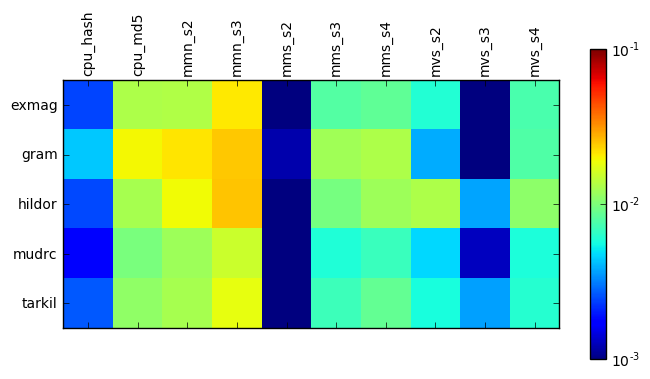

{'gram': 1096.0298553829998, 'tarkil': 1308.1805718760002, 'exmag': 1252.2465004969999, 'hildor': 1348.718058591, 'mudrc': 2670.0428200890001}
{'cpu_hash': 0.88215297605024379, 'mms_s2': 0.50443885718836667, 'mmn_s3': 0.37182139867238889, 'mvs_s3': 0.32224510508464271, 'mms_s4': 0.54291443304192588, 'cpu_md5': 0.78152519127831543, 'mvs_s2': 0.40842186280236448, 'mvs_s4': 0.50585171952272601, 'mms_s3': 0.39551098198267737, 'mmn_s2': 0.28511747437634871}


In [2]:
D.ftol       = 1e-5
D.xtol       = D.ftol
D.test_drop = [
    'mem_l1', 'mem_l2', 'mem_l3', 
    'cpu_simple', 'mmn_s4', 'mem_ll',
    'mvs_s1', 'mms_s1', 'mmn_s1',
    #'cpu_hash', 'cpu_md5'
]
D.mach_drop = [
    'ajax', 'luna'
]
cut_count    = 15
repetition   = 50
versions     = '1.1.1', '1.1.2', '1.1.3', '1.1.4', '1.1.5'
#versions     = '1.0.2', '1.0.3', '1.0.4', '1.0.5'

d = D(load_data(version=versions[0]))
baseline = d.estimate_abcm()

stats = 'min', 'mean', 'max'
df = pd.DataFrame(
    [getattr(np, f)(baseline.rel_error.values.flatten()) for f in stats],
    index=stats,
    columns=['stats']
).T
display(df)

display(baseline.ab)
display(baseline.cm)
baseline.plot_error()

D.ftol     = 1e-4
D.xtol     = D.ftol

print(d.norm_mach)
print(d.norm_test)

In [3]:
estimates = {}
bar = progressbar.ProgressBar(
    fd=sys.stdout,
    term_width=80,
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(marker='='),
        ' (', progressbar.ETA(), ') ',
    ]
)

def estimate_version(version, repetition, test_data_size):
    if cut_count not in estimates:
        estimates[cut_count] = dict()
        
    estimates[cut_count][version] = list()
    bar.max_value = repetition
    with bar:
        for i in range(repetition):
            bar.update(i)

            d = D(load_data(version=version))
            if test_data_size:
                d.cut_data(count=test_data_size)
            e = d.estimate_cm(baseline.ab)

            estimates[cut_count][version].append(e)

In [4]:
cut_count    = 15
#means = {t:m for t in baseline.all}
means = None
new_means = None
stat_test = 0
for version in versions:
    if stat_test:
        d = D(load_data(version=version), False)
        v = d.all['mudrc']['mms_s4']
        new_means = d.dict2df(d.make_reference())
        #new_means = new_means['mvs_s3']
        new_means = new_means.drop('mvs_s3', axis=1)

        if means is None:
            means = new_means
        else:

            diff = np.divide(abs(means-new_means), means)*100
            #diff = means#np.divide(abs(means-new_means), means)*100
            print(version)
            print(np.std(diff.values.flatten()))
            print(st.variation(diff.values.flatten()))
            print(np.mean(diff.values.flatten()))
            display(diff)
            print()
            means = new_means
        continue
        
    estimate_version(
        version=version,
        repetition=repetition,
        test_data_size=cut_count
    )

 [Elapsed Time: 0:00:45] |====================================| (Time: 0:00:45) 
 [Elapsed Time: 0:00:52] |====================================| (Time: 0:00:52) 
 [Elapsed Time: 0:00:54] |====================================| (Time: 0:00:54) 
 [Elapsed Time: 0:00:54] |====================================| (Time: 0:00:54) 
 [Elapsed Time: 0:00:46] |====================================| (Time: 0:00:46) 


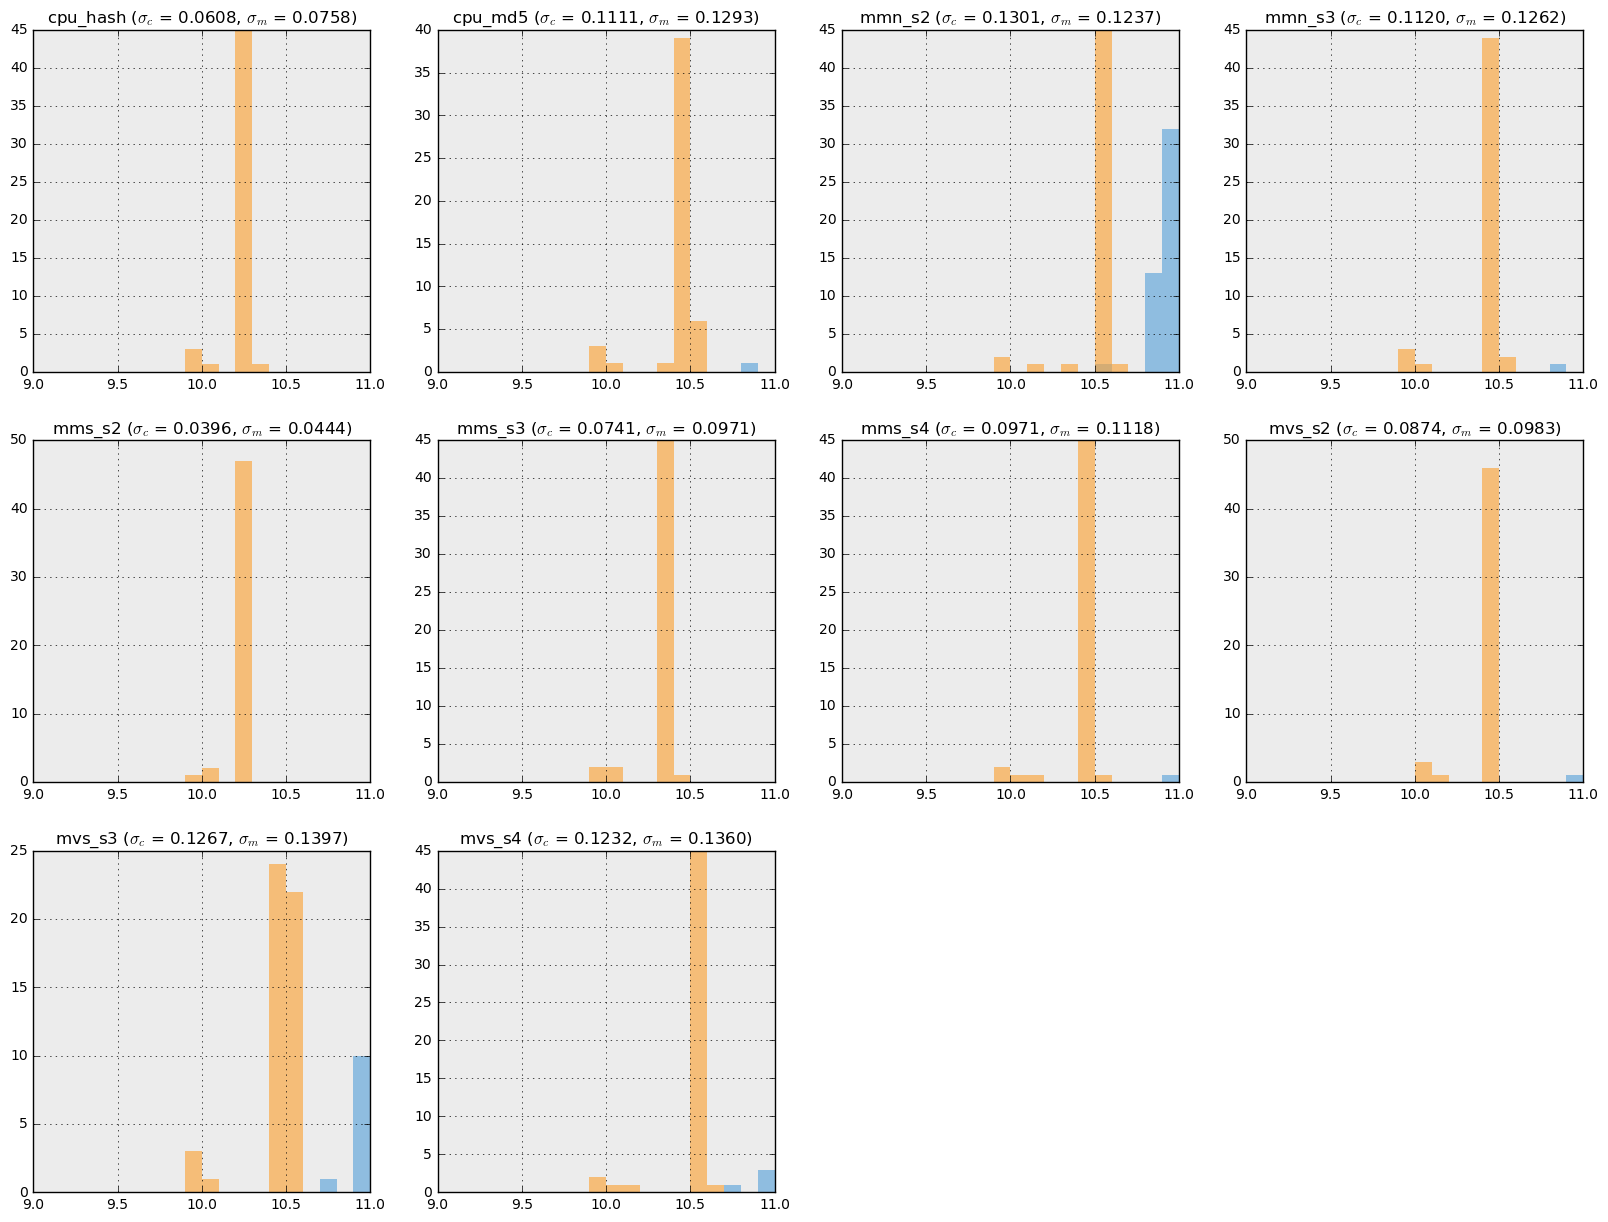

In [5]:
%matplotlib inline

final_cpu  = np.array([e.cm.values[0] for e in estimates[cut_count][version]])
final_mem  = np.array([e.cm.values[1] for e in estimates[cut_count][version]])

fig = plt.figure(figsize=(20, 15))
plt.rcParams['axes.facecolor']    = '#ececec'
plt.rcParams['savefig.facecolor'] = '#ececec'

for i in range(final_cpu.shape[1]):
    test = baseline.test_list[i]
    cpu_data = final_cpu[:, i]
    mem_data = final_mem[:, i]
    std_cpu = np.std(cpu_data)
    std_mem = np.std(mem_data)
    bins = np.linspace(9, 11, 21)
    
    #his, bins = np.histogram(np.hstack((cpu_data, mem_data)), 20)
    
    density_cpu = st.gaussian_kde(cpu_data, 0.1)
    density_mem = st.gaussian_kde(mem_data, 0.1)
    
    plt.subplot(3, 4, i+1)
    plt.title('{:} ($\sigma_{{c}}$ = {:1.4f}, $\sigma_{{m}}$ = {:1.4f})'.format(test, std_cpu, std_mem))
    plt.grid()

    #plt.plot(bins, density_cpu(bins), color=c1d)
    #plt.plot(bins, density_mem(bins), color=c2d)
    #plt.hist(cpu_data, color=c1, alpha=0.75, lw=0)
    #plt.hist(mem_data, color=c2, alpha=0.75, lw=0)
    plt.hist(cpu_data, bins, color=c1, alpha=0.65, lw=0)
    plt.hist(mem_data, bins, color=c2, alpha=0.65, lw=0)
    
    
plt.savefig('std-cpu-mem-{cut_count}-{repetition}-{D.ftol}.pdf'.format(**locals()))

versions-15-50-0.0001.pdf


,mean,std
cpu_hash,10.458299,0.093280
cpu_md5,10.100698,0.106889
mmn_s2,9.766129,0.101841
mmn_s3,10.134550,0.051601
mms_s2,10.561930,0.045177
mms_s3,10.328181,0.061917
mms_s4,10.167252,0.069377
mvs_s2,10.228942,0.074589
mvs_s3,10.153371,0.074522
mvs_s4,10.041260,0.132105


mean    10.194061
std      0.081130
dtype: float64

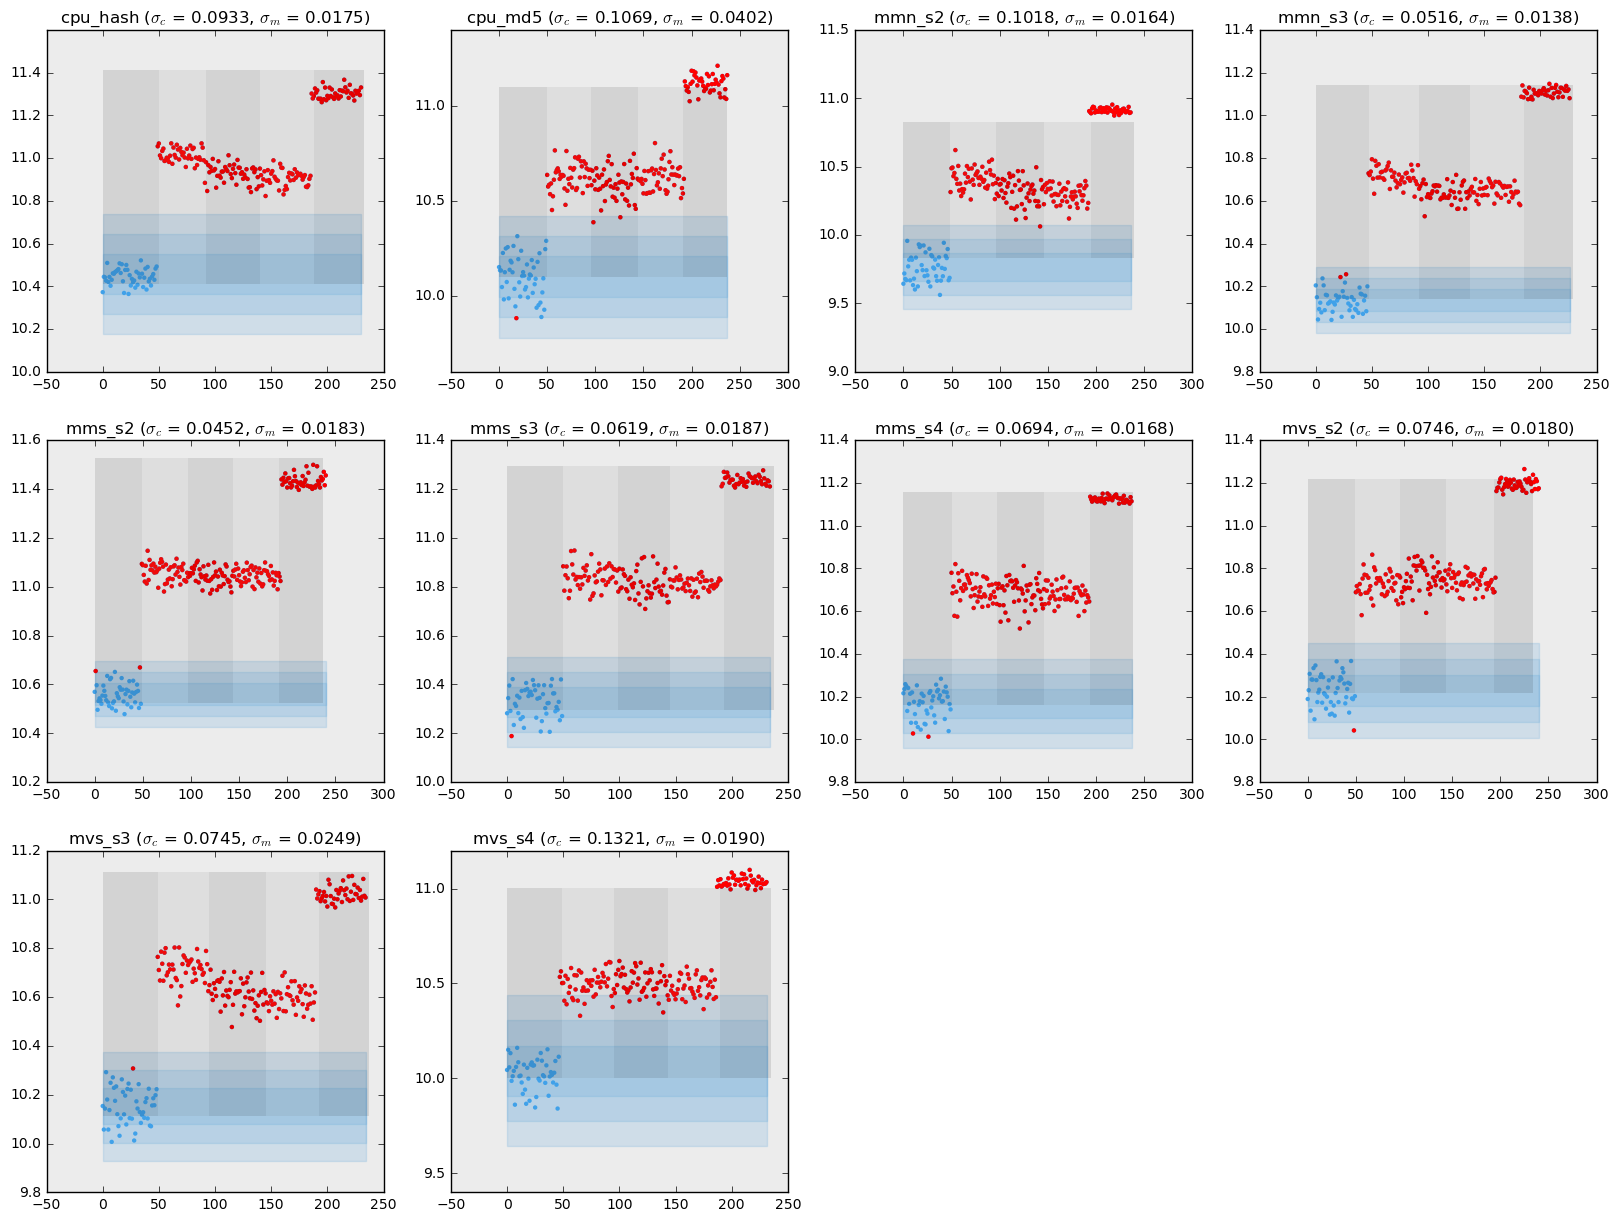

In [6]:
%matplotlib inline
versions_count = {test:{} for test in baseline.test_list}
colors = '#FFAAAA', '#FFEAAA', '#8180B2', '#88CC88'
colors = ['#000000', '#666666'] * 5

result    = []
final_cpu = {test:[] for test in baseline.test_list}
final_mem = {test:[] for test in baseline.test_list}


cut_count = 15
# iterate all versions, and vstack all values
for version in versions:
    values_cpu = {test:[] for test in baseline.test_list}
    values_mem = {test:[] for test in baseline.test_list}
    
    for e in estimates[cut_count][version]:     
        for test in baseline.test_list:
            alpha, beta = e.cm[test].values
            values_cpu[test].append(alpha)
            values_mem[test].append(beta)
            
    for test in baseline.test_list:
        iqr_values = iqr(values_cpu[test])
        versions_count[test][version] = len(iqr_values)
        final_cpu[test].extend(iqr_values)
        
        iqr_values = iqr(values_mem[test])
        versions_count[test][version] = len(iqr_values)
        final_mem[test].extend(iqr_values)
        
    #final_cpu.append(values_cpu)
    #final_mem.append(e.cm.values[1])


cpu_means = []
fig = plt.figure(figsize=(20, 15))
for test in baseline.test_list:
    i = np.where(baseline.test_list == test)[0][0]
    data_cpu = final_cpu[test]
    data_mem = final_mem[test]
    data_mean = np.mean(np.hstack((data_cpu, )).flatten())
    ax = plt.subplot(3, 4, i+1)
    cpu_length = len(data_cpu)
    
    data_cpu_smooth = data_cpu#smooth(data_cpu, 11, 'hanning')[0:cpu_length]
    data_cpu_all = np.arange(cpu_length), data_cpu_smooth   
                     
    x = 0
    j = 0
       
    d_cpu = data_cpu[0:versions_count[test][versions[0]]]
    std_cpu, mean_cpu = np.std(d_cpu), np.mean(d_cpu)
    upper_cpu = np.array([mean_cpu] * cpu_length)
    lower_cpu = np.array([mean_cpu] * cpu_length)
    
    cpu_means.append((mean_cpu, std_cpu))
      
    d_mem = data_mem[0:versions_count[test][versions[0]]]
    std_mem, mean_mem = np.std(d_mem), np.mean(d_mem)
    upper_mem = np.array([mean_mem] * cpu_length)
    lower_mem = np.array([mean_mem] * cpu_length)
    
    overs = outside_bounds(*data_cpu_all, ucl=upper_cpu + std_cpu*2, lcl=upper_cpu - std_cpu*2)
    
    for version in versions:
        l = versions_count[test][version]
        d = data_cpu[x:x+l]
        ax.add_patch(
            patches.Rectangle(
                (x, data_mean - .5),
                l, 1,
                color=colors[j],
                alpha=0.1,
                lw=0
            )
        )
        x += l
        j += 1
    
    
    plt.fill_between(
        np.arange(len(upper_cpu)),
        upper_cpu + std_cpu, lower_cpu - std_cpu,
        color=c1, alpha=0.2
    )
    plt.fill_between(
        np.arange(len(upper_cpu)),
        upper_cpu + std_cpu*2, lower_cpu - std_cpu*2,
        color=c1, alpha=0.2
    )
    plt.fill_between(
        np.arange(len(upper_cpu)),
        upper_cpu + std_cpu*3, lower_cpu - std_cpu*3,
        color=c1, alpha=0.2
    )

    plt.scatter(*data_cpu_all, c=c1d, edgecolor='none', marker='o', s=10);
    plt.scatter(*overs, c='red', edgecolor='none', marker='o', s=10);
    
    plt.title('{:} ($\sigma_{{c}}$ = {:1.4f}, $\sigma_{{m}}$ = {:1.4f})'.format(test, std_cpu, std_mem))
    #plt.ylim((data_mean - .25, data_mean + .25))
    #plt.xlim(0, cpu_length)
    #plt.plot(data_cpu, c=c1d);
    


    
    
    #plt.plot(smooth(data_mem, 11, 'hanning'), c=c2d);
    #plt.fill_between(
    #    np.arange(len(upper_mem)),
    #    np.array(upper_mem), np.array(lower_mem),
    #    color=c2, alpha=0.3
    #)
    #plt.plot(data_mem, c=c2d);
    
plt.savefig('versions-{cut_count}-{repetition}-{D.ftol}.pdf'.format(**locals()))
print('versions-{cut_count}-{repetition}-{D.ftol}.pdf'.format(**locals()))

cpu_stat = pd.DataFrame(cpu_means, columns=('mean', 'std'), index=baseline.test_list)
display(cpu_stat)
display(cpu_stat.mean())


0.288763514327 -0.271891116769


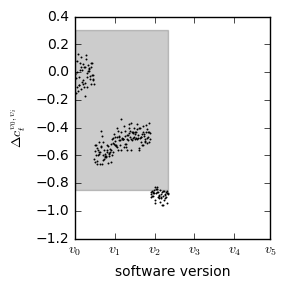

In [7]:
%matplotlib inline
fig = plt.figure(figsize=(3, 3))
plt.rcParams['axes.facecolor']    = '#FFFFFF'
plt.rcParams['savefig.facecolor'] = '#FFFFFF'

test = 'mvs_s3'
data_cpu = np.array(final_cpu[test])
#data_cpu = -((data_cpu - np.mean(data_cpu[0:90])) * 240)
#data_cpu = abs(-data_cpu)
delta = baseline.cm[test][0] - data_cpu
d = D(load_data(version=version), False)
data_cpu = delta

cpu_length = len(data_cpu)
smoothed = data_cpu#smooth(data_cpu, 11, 'hanning')[0:cpu_length]
Y = np.arange(cpu_length)
plt.scatter(Y, smoothed, s=2, lw=0, c='#000000')
cpu_mean = np.mean(data_cpu[0:90])
cpu_std  = np.std(data_cpu[0:90])

plt.fill_between(
    np.arange(cpu_length),
    cpu_mean + cpu_std*2, cpu_mean - cpu_std*2,
    color='#000000', alpha=0.2
)
plt.xticks([0, 100, 200, 300, 400, 490], ['$v_%d$' % i for i in range(6)])
plt.xlabel('software version')
plt.ylabel('$\Delta c_t^{v_0,v_i}$')
plt.xlim(0, 490)
#plt.ylim(-20, 40)
plt.tight_layout()
plt.savefig('test-detail.pdf')
print(cpu_std, cpu_mean)

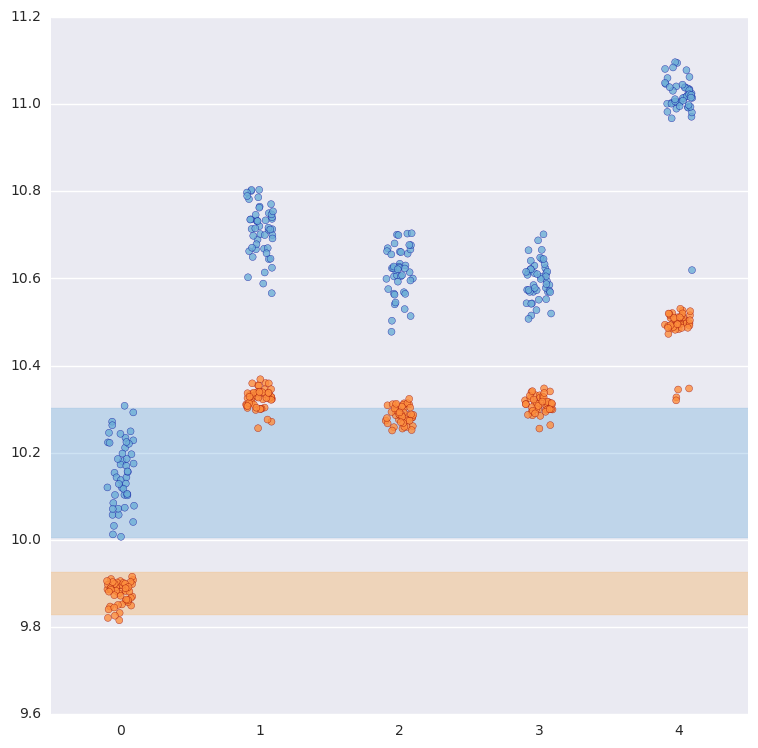

In [8]:
%matplotlib inline

import seaborn as sns
import warnings
from operator import itemgetter, attrgetter
warnings.filterwarnings('ignore')
test = 'mvs_s3'

data_cpu = final_cpu[test]
data_mem = final_mem[test]

#plt.plot(data_cpu)
#plt.plot(data_mem)

pc = 0
data_cpu_all = []
data_mem_all = []
cpu_first_mean, cpu_first_std = 0, 0
mem_first_mean, mem_first_std = 0, 0
for version in versions_count[test]:
    cnt = pc + versions_count[test][version]
    data_cpu_all.append(data_cpu[pc:cnt])
    data_mem_all.append(data_mem[pc:cnt])
    if not cpu_first_mean:
        cpu_first_std = np.std(data_cpu[pc:cnt])
        cpu_first_mean = np.mean(data_cpu[pc:cnt])
        
        mem_first_std = np.std(data_mem[pc:cnt])
        mem_first_mean = np.mean(data_mem[pc:cnt])
    print()
    pc = cnt

#data_all = pd.DataFrame(data_all)
fig = plt.figure(figsize=(9, 9))
sns.stripplot(data=data_cpu_all, jitter=True, linewidth=0.3, alpha=.8, edgecolor='#000099', palette=sns.color_palette("Blues_r", n_colors=1))
sns.stripplot(data=data_mem_all, jitter=True, linewidth=0.3, alpha=.8, edgecolor='#990000', palette=sns.color_palette("Oranges_r", n_colors=1))

plt.fill_between(
    np.arange(len(data_cpu_all)+20)-10,
    cpu_first_mean + cpu_first_std*2, cpu_first_mean - cpu_first_std*2,
    color=c1, alpha=0.3
)

plt.fill_between(
    np.arange(len(data_mem_all)+20)-10,
    mem_first_mean + mem_first_std*2, mem_first_mean - mem_first_std*2,
    color=c2, alpha=0.3
)

d = D(load_data(version=versions[0]))
baseline = d.estimate_abcm()
